In [1]:
import torch
from pytorch_model_summary import summary
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch as t
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random
from pycocotools.coco import COCO
import os

from torchvision.transforms.functional import to_tensor
from IPython.display import clear_output
import time

In [17]:
coco = COCO(os.path.join("american-sign-language-letters-coco/", "train/_annotations.coco.json"))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
print(coco.anns[0])

{'id': 0, 'image_id': 0, 'category_id': 21, 'bbox': [38, 69, 309, 320], 'area': 98880, 'segmentation': [], 'iscrowd': 0}


In [27]:
print(coco.getImgIds())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [28]:
print(coco.getCatIds())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [47]:
print(coco.getAnnIds()[0])

0


In [46]:
print(coco.loadImgs(coco.getAnnIds()[0])[0])

{'id': 0, 'license': 1, 'file_name': 'U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg', 'height': 390, 'width': 390, 'date_captured': '2020-10-20T16:55:24+00:00'}


In [44]:
print(coco.loadAnns(0)[0])

[{'id': 0, 'image_id': 0, 'category_id': 21, 'bbox': [38, 69, 309, 320], 'area': 98880, 'segmentation': [], 'iscrowd': 0}]


In [12]:
class HandsDataset(Dataset):
  def __init__(self, coco_annos, coco_imgs, img_size=(320, 320)):
    """
    Args:
        dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
        width (int): target image width.
        height (int): target image height.
    """
    self.coco_annos = coco_annos
    self.coco_imgs = coco_imgs

    self.coco_anno_file = coco_annos
    self.coco_imgs_dir = coco_imgs
    print(self.coco_anno_file)
    self.coco = COCO(self.coco_anno_file)

    self.img_size = img_size

    self.init_dataset()

  def init_dataset(self):
    self.cat_ids = self.coco.getCatIds()

    self.img_ids = self.coco.getImgIds()
    self.ann_ids = self.coco.getAnnIds(self.img_ids)

    print("Dataset size {}".format(len(self.img_ids)))

  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, idx):
    img_meta = self.coco.loadImgs(self.img_ids[idx])[0]
    img_path = os.path.join(self.coco_imgs_dir, img_meta['file_name'])
    img = Image.open(img_path)
    ann_id = self.coco.getAnnIds(self.img_ids[idx])
    annos = self.coco.loadAnns(ann_id)[0]

    original_width, original_height = img.size

    img = img.resize(self.img_size)
    img = np.array(img)

    if len(img.shape) == 2:
      img = np.expand_dims(img, axis=2)
      img = np.repeat(img, 3, axis=2)

    img = to_tensor(img)

    bbox = annos['bbox']  # box is xywh
    cat_id = annos['category_id']

    x1, y1, w, h = bbox
    x2, y2 = x1 + w, y1 + h

    # x1 = x1 / original_width * self.img_size[0]
    # x2 = x2 / original_width * self.img_size[0]
    # y1 = y1 / original_height * self.img_size[1]
    # y2 = y2 / original_height * self.img_size[1]

    x1 = x1 / original_width
    x2 = x2 / original_width
    y1 = y1 / original_height
    y2 = y2 / original_height

    coordinates = np.array([x1, y1, x2, y2])
    coordinates =  coordinates.astype(np.float32)

    return img, coordinates, cat_id

In [13]:
coco_root = "american-sign-language-letters-coco/"
coco_anno_train = os.path.join(coco_root, "train/_annotations.coco.json")
coco_imgs_train = os.path.join(coco_root, "train")

coco_anno_valid = os.path.join(coco_root, "valid/_annotations.coco.json")
coco_imgs_valid = os.path.join(coco_root, "valid")

dataset_train = HandsDataset(coco_anno_train, coco_imgs_train, img_size=(224, 224))
dataset_valid = HandsDataset(coco_anno_valid, coco_imgs_valid, img_size=(224, 224))

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=1, shuffle=False) # keep batch_size=1

american-sign-language-letters-coco/train/_annotations.coco.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset size 1512
american-sign-language-letters-coco/valid/_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset size 144


torch.Size([16, 224, 224, 3])
tensor([0.1571, 0.2775, 0.7705, 0.8116])


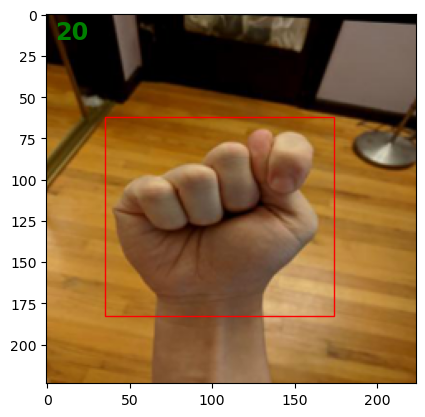

In [58]:
see_examples = 3
for i, (imgs, coordinates, cat_id) in enumerate(train_loader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    print(imgs.shape)

    plt.imshow(imgs[0])
    
    print(coordinates[0])
    
    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset_train.img_size[1]
    y1 = y1 * dataset_train.img_size[0]
    x2 = x2 * dataset_train.img_size[1]
    y2 = y2 * dataset_train.img_size[0]
    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(5, 15, cat_id[0].item(), fontsize='xx-large', color='g', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)

In [ ]:
img = read_image("test_img.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

In [54]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [53]:
# freeze the backbone
for p in model.backbone.parameters():
    p.requires_grad = False
for p in model.roi_heads.box_head.fc6.parameters():
    p.requires_grad = False